<a href="https://colab.research.google.com/github/EmmarieR/CNM-DeepDive-Data-Science-Projects/blob/main/Project_5_NLP_ER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing



This project will give you practical experience using Natural Language Processing techniques. This project is in three parts:
- in part 1) you will use a dataset in a CSV file
- in part 2) you will use the Wikipedia API to directly access content
on Wikipedia.
- in part 3) you will make your notebook interactive


#imports

In [1]:
!pip install wikipedia-api

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15383 sha256=c95068a3ab9005439f3b301d98afa34a6c98c35c030b090178266ef411b88b52
  Stored in directory: /root/.cache/pip/wheels/0b/0f/39/e8214ec038ccd5aeb8c82b957289f2f3ab2251febeae5c2860
Successfully built wikipedia-api


In [263]:
import pandas as pd
import numpy as np

import urllib.parse
from io import StringIO
import requests

import requests
from bs4 import BeautifulSoup
import wikipediaapi

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer as BagOfWords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import urllib.parse

# Part 1)



- The CSV file is available at https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv
- The file contains a list of famous people and a brief overview.
- The goal of part 1) is to ...
  1. Pick one person from the list ( the target person ) and output 10 other people who's overview are "closest" to the target person in a Natural Language Processing sense
  1. Also output the sentiment of the overview of the target person



In [3]:
!curl -s https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv | wc -l

42786


## Read in Data

In [4]:
# read in the csv to pandas
names_df = pd.read_csv('https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv')

In [5]:
names_df.head(20)

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
5,<http://dbpedia.org/resource/Sam_Henderson>,Sam Henderson,sam henderson born october 18 1969 is an ameri...
6,<http://dbpedia.org/resource/Aaron_LaCrate>,Aaron LaCrate,aaron lacrate is an american music producer re...
7,<http://dbpedia.org/resource/Trevor_Ferguson>,Trevor Ferguson,trevor ferguson aka john farrow born 11 novemb...
8,<http://dbpedia.org/resource/Grant_Nelson>,Grant Nelson,grant nelson born 27 april 1971 in london also...
9,<http://dbpedia.org/resource/Cathy_Caruth>,Cathy Caruth,cathy caruth born 1955 is frank h t rhodes pro...


In [6]:
names_df.shape

(42786, 3)

In [7]:
names_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42786 entries, 0 to 42785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     42786 non-null  object
 1   name    42786 non-null  object
 2   text    42786 non-null  object
dtypes: object(3)
memory usage: 1002.9+ KB


no nulls, but it looks like we may have to clean up the names column to only show names in a common format.

then parse the text for identifying text. filter out common, uninformative words like 'the', 'and' 'it'

working with AMS csv dataset of famous people. There are 42786 rows and 3 data columns: name, URI, text. The dataset is 1002.9 KB.

## Data Cleaning

look through names and check to see that all entries are unique

In [8]:
# find repeated names
names_df.name.value_counts()

,count
name,
author),2
Kate Fodor,1
Kreg Battles,1
Robert Earnshaw,1
Clay Christiansen (organist),1
...,...
Chet Walker,1
Andreas Vanpoucke,1
Jill Robinson,1


weird that there is a repeated name, and that some names have information about the person. I may split these info nuggets into a new column later. Let's look at that repeat right now.

In [9]:
# look at the two instances of 'author)'
names_df[names_df.name == 'author)']

,URI,name,text
787,<http://dbpedia.org/resource/James_Grieve_(tra...,author),james grieve born 1934 is an australian transl...
17249,<http://dbpedia.org/resource/Steve_Greenberg_(...,author),steve greenberg december 20 1960 is an america...


I'll fix these two entries to have the names listed within the URI.

In [10]:
# input name for row 787 to be 'James Grieve'
names_df.loc[787, 'name'] = 'James Grieve'

# input name for row 17249 to be 'Steve Greenburg'
names_df.loc[17249, 'name'] = 'Steve Greenburg'

In [11]:
names_df.name.value_counts()

,count
name,
Kenneth Thomas,1
Digby Morrell,1
Luke Walsh,1
Rachel Mackley,1
Martin Lee (tennis),1
...,...
Aaron LaCrate,1
Sam Henderson,1
G-Enka,1


In [12]:
# place info nugget into new column
for index, row in names_df.iterrows():
  if '(' in row['name']:
    names_df.loc[index, 'info_nugget'] = row['name'].split('(')[1].split(')')[0]
    names_df.loc[index, 'name'] = row['name'].split('(')[0]
  else:
    names_df.loc[index, 'info_nugget'] = 'tbd'

names_df.head(25)

,URI,name,text,info_nugget
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,tbd
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,tbd
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,tbd
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,tbd
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,tbd
5,<http://dbpedia.org/resource/Sam_Henderson>,Sam Henderson,sam henderson born october 18 1969 is an ameri...,tbd
6,<http://dbpedia.org/resource/Aaron_LaCrate>,Aaron LaCrate,aaron lacrate is an american music producer re...,tbd
7,<http://dbpedia.org/resource/Trevor_Ferguson>,Trevor Ferguson,trevor ferguson aka john farrow born 11 novemb...,tbd
8,<http://dbpedia.org/resource/Grant_Nelson>,Grant Nelson,grant nelson born 27 april 1971 in london also...,tbd
9,<http://dbpedia.org/resource/Cathy_Caruth>,Cathy Caruth,cathy caruth born 1955 is frank h t rhodes pro...,tbd


In [13]:
names_df.info_nugget.value_counts()

,count
info_nugget,
tbd,38183
musician,280
politician,220
footballer,213
baseball,185
...,...
ice hockey b. 1945,1
enduro rider,1
"first baseman, born 1971",1


cool, just learned that an enduro rider is essentially a cross country motorcyclist from this.

In [14]:
# save a copy of the df
names_df1 = names_df.copy()

Next, let's take a stab at formatting the names and the text.

In [15]:
# format names column
names_df1['name'] = names_df1['name'].apply(lambda x: urllib.parse.unquote(x).lower())
names_df1['name'] = names_df1['name'].str.replace(' ', '_', regex=False)
names_df1['name'] = names_df1['name'].str.replace('-', '_', regex=False)
names_df1['name'] = names_df1['name'].str.replace('.', '_', regex=False)
names_df1['name'] = names_df1['name'].str.replace('[^a-z_]', '', regex=True)

# format text column
names_df1['text'] = names_df1['text'].str.lower()

# format info nugget
names_df1['info_nugget']= names_df1['info_nugget'].str.lower()

##Bag-of-Words: Nearest Neighbors and Sentiment

Let's begin to parse the text provided

In [16]:
# pick a random person from name column
target_name = np.random.choice(names_df1.name)
print(target_name)

target_row = names_df1[names_df1['name'] == target_name]

farhan_nizami


In [17]:
# list of text column entries
all_text = names_df1['text'].astype(str).tolist()

# vectorize using Bag of Words
vectorizer = CountVectorizer(stop_words='english')
bow_matrix = vectorizer.fit_transform(all_text)

# find cosine similarity between entries
target_index = target_row.index[0]
cos_similarities = cosine_similarity(bow_matrix[target_index], bow_matrix).flatten()

In [18]:
# get top 10 similar people (excluding self)
similar_indices = cos_similarities.argsort()[-11:-1][::-1]
similar_people = names_df1.iloc[similar_indices][['name', 'text']]

# return similar people
print(f"\nTop 10 people similar to '{target_name}':")
for i, row in similar_people.iterrows():
    print(f"- {row['name']}")

# sentiment analysis of target person's overview
target_overview = target_row['text'].values[0]
sentiment = TextBlob(target_overview).sentiment
print(f"\nSentiment of {target_name}'s overview:")
print(f"Polarity: {sentiment.polarity:.2f}, Subjectivity: {sentiment.subjectivity:.2f}")


Top 10 people similar to 'farhan_nizami':
- geoffrey_thomas_
- timothy_barnes
- daniel_walker_howe
- robert_g__hoyland
- gabriel_gorodetsky
- deian_hopkin
- mohammad_najatuallah_siddiqui
- mohammed_amin_
- richard_smethurst
- muhammad_khalid_masud

Sentiment of farhan_nizami's overview:
Polarity: 0.05, Subjectivity: 0.22


looks like things work, but there's typos in the names still, i'll go back and fix later. (edit: fixed above in data cleaning)

# Part 2)



- For the same target person that you chose in Part 1), use the Wikipedia API to access the whole content of the target person's Wikipedia page.
- The goal of Part 2) is to ...
  1. Print out the text of the Wikipedia article for the target person
  1. Determine the sentiment of the text of the Wikipedia page for the target person
  1. Collect the text of the Wikipedia pages from the 10 nearest neighbors from Part 1)
  1. Determine the nearness ranking of these 10 people to your target person based on their entire Wikipedia page
  1. Compare, i.e. plot,  the nearest ranking from Step 1) with the Wikipedia page nearness ranking.  A difference of the rank is one means of comparison.



## dbpedia DOI --> wikipedia URL : Beatiful Soup

*Caution you may receive a 502 error here. not an error in the code, but just poor connection to wi-fi or server. Wait it out, and error should resolve.*

In [143]:
import time
import requests
from requests.exceptions import RequestException

def doi(target_name):
    """
    Given Target person's name, return dbpedia doi from name df and return request response.
    Includes retry mechanism for handling intermittent connection issues.
    """
    # find and format doi from df
    doi_name = names_df1[names_df1['name'] == target_name]['URI'].values[0]
    doi_name = doi_name.lstrip('<').rstrip('>')

    # Retry mechanism with exponential backoff
    max_retries = 10
    retry_delay = 10  # Initial delay in seconds
    for attempt in range(max_retries):
        try:
            dbpedia = requests.get(doi_name)
            dbpedia.raise_for_status()  # Raise HTTPError for bad responses
            return dbpedia
        except RequestException as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < max_retries - 1:
                time.sleep(retry_delay)
                retry_delay *= 1  # Exponential backoff
            else:
                print(f"Failed to fetch dbpedia after {max_retries} attempts.")
                # Handle the error as needed, e.g., return None or raise an exception
                return None




In [94]:
target_dbpedia = doi(target_name)

In [95]:
def bs_parser(dbpedia):
  """Given dbpedia dbpedia link, return wikipedia url"""

  # target dbpedia html code
  html = dbpedia.text

  # call beautiful soup dom html parser for selecting a-tags
  dom = BeautifulSoup(html, "html.parser")
  a_tags = dom.select("a")

  # find wiki link for target
  # Initialize wiki_url to None before the loop
  wiki_url = None
  for a_tag in a_tags:
    href = a_tag.attrs["href"]
    if href.startswith("http"):
      rev = a_tag.attrs.get("rev","")
      if "foaf:primaryTopic" in rev:
        wiki_url = href
        print(href)

  # Check if wiki_url is still None after the loop and handle accordingly
  if wiki_url is None:
    print("Wikipedia URL not found in dbpedia page.")
    return None
    # Or raise an exception:
    # raise ValueError("Wikipedia URL not found in dbpedia page.")

  return wiki_url

In [96]:
target_wiki_url = bs_parser(target_dbpedia)

http://en.wikipedia.org/wiki/Farhan_Nizami


## Wikipedia info

In [97]:
# wikipedia API setup
wiki = wikipediaapi.Wikipedia(
    language='en',
    user_agent='Big Bad Wolf' # let me in, let me in, wikipedia!
)

def get_wiki_text(wiki_url):
  """Given the URL to target person's wikipedia page, return wikipedia page title and first 5000 characters from page article.
  If page is not found, return error message.
  """

  # extract page title from URL
  page_title = wiki_url.rsplit('/', 1)[-1]

  # fetch full article text
  page = wiki.page(page_title)

  if page.exists():
    wiki_text = page.text
    print(f"\nTitle: {page.title}")
    print(f"Summary (first 500 chars):\n{page.text[:500]}")
    return wiki_text
  else:
    print("Page not found.")

In [98]:
target_wiki_text = get_wiki_text(target_wiki_url)


Title: Farhan Nizami
Summary (first 500 chars):
Farhan Nizami CBE is a historian of South Asia.

Early life and education
Nizami is the youngest of five children of the historian K. A. Nizami and Razia Nizami.
Nizami completed his B.A. (Hons.) and M.A. in history at Aligarh Muslim University with a first class. He was awarded the University Medal, and the Khursheed Nurul Hasan Gold Medal in 1977. He was a National Scholar at the Centre for Advanced Study in History (1977–79) and the recipient of the University Medal in 1979. He completed his 


## Wiki: Sentiment

In [99]:
def get_sentiment(wiki_text):
  """Given the article text from wikipedia, return sentiment polarity and subjectivity values"""

  # sentiment analysis of target person's overview
  sentiment_wiki = TextBlob(wiki_text).sentiment
  print(f"\nSentiment of {target_name}'s overview:")
  print(f"Polarity: {sentiment_wiki.polarity:.2f}, Subjectivity: {sentiment_wiki.subjectivity:.2f}")

In [100]:
get_sentiment(target_wiki_text)


Sentiment of farhan_nizami's overview:
Polarity: 0.12, Subjectivity: 0.20


## Wiki: Nearest Neighbors Info

Let's make a list of the nearest neighbors for iteration.

In [102]:
# neighbor indices
similar_indices

array([41096,  3458, 34492,  3790, 33748,  2131, 19105, 29294, 34775,
       18836])

In [103]:
# make list of nearest neighbor names
neighbors = []
for index in similar_indices:
  neighbors.append(names_df1.iloc[index]['name'])
  print(names_df1.iloc[index]['name'])

geoffrey_thomas_
timothy_barnes
daniel_walker_howe
robert_g__hoyland
gabriel_gorodetsky
deian_hopkin
mohammad_najatuallah_siddiqui
mohammed_amin_
richard_smethurst
muhammad_khalid_masud


In [142]:
# call empty list to catch wiki article texts
neighbors_text = []

# grab doi, bs_parser, get_wiki_info, and get_sentiment for each neighbor
for name in neighbors:
  dbpedia = doi(name)
  wiki_url = bs_parser(dbpedia)
  wiki_text = get_wiki_text(wiki_url)
  get_sentiment(wiki_text)
  print('\n')

  # save wikipedia text to an array
  neighbors_text.append(wiki_text)

neighbors_text_arr = np.array(neighbors_text)

http://en.wikipedia.org/wiki/Geoffrey_Thomas_(academic)

Title: Geoffrey Thomas (academic)
Summary (first 500 chars):
Geoffrey Price Thomas FLSW (born 3 July 1941) was President of Kellogg College, Oxford, and Director of Oxford University Department for Continuing Education until 2008.
He was educated at Maesteg Grammar School, University of Wales (Swansea) (BSc, (First Class Honours, Physics)) and Churchill College, Cambridge (PhD). He is also a Master of Arts of the University of Oxford.
Following one year as a research associate at the Cavendish Laboratory at the University of Cambridge (1966–67), he became

Sentiment of farhan_nizami's overview:
Polarity: 0.05, Subjectivity: 0.21


http://en.wikipedia.org/wiki/Timothy_Barnes

Title: Timothy Barnes
Summary (first 500 chars):
Timothy or Tim Barnes may refer to:

Timothy Barnes (classicist) (born 1942), British classicist
Timothy Barnes, 4th Baron Gorell (1927–2007), British businessman
Tim Barnes (politician) (born 1958), member of 

*Caution you may receive a 502 error here. not an error in the code, but just poor connection to wi-fi or server. Wait it out, and error should resolve. EDIT: added in retry command in case of failed access attempt(s).*

In [186]:
neighbors_text_arr

array(["Geoffrey Price Thomas FLSW (born 3 July 1941) was President of Kellogg College, Oxford, and Director of Oxford University Department for Continuing Education until 2008. He was educated at Maesteg Grammar School, University of Wales (Swansea) (BSc, (First Class Honours, Physics)) and Churchill College, Cambridge (PhD). He is also a Master of Arts of the University of Oxford. Following one year as a research associate at the Cavendish Laboratory at the University of Cambridge (1966–67), he became a Staff Tutor at University College of Swansea (1967–78). In 1978 he moved to the University of Oxford as Fellow of Linacre College and Deputy Director of the Department of External Studies. In 1986 he became Director of Oxford University Department for Continuing Education. He remained a Fellow of Linacre until 1990, when he became the first President of Kellogg College and an Honorary Fellow of Linacre. He has been a visiting scholar at the Smithsonian Institution, Harvard University,

In [187]:
# remove /n from text
neighbors_text_arr = np.char.replace(neighbors_text_arr, '\n', ' ')
neighbors_text_arr

# convert arr to df and add back in the neighbor name
neighbors_df = pd.DataFrame(neighbors_text_arr, columns=['wiki_text'])
neighbors_df['name'] = neighbors
neighbors_df

,wiki_text,name
0,Geoffrey Price Thomas FLSW (born 3 July 1941) ...,geoffrey_thomas_
1,Timothy or Tim Barnes may refer to: Timothy B...,timothy_barnes
2,"Daniel Walker Howe (born January 10, 1937) is ...",daniel_walker_howe
3,"Robert G. Hoyland (born 1966) is a historian, ...",robert_g__hoyland
4,Gabriel Gorodetsky (Hebrew: גבריאל גורודצקי; b...,gabriel_gorodetsky
5,Sir Deian Rhys Hopkin (born 1 March 1944) is a...,deian_hopkin
6,Mohammad Nejatullah Siddiqi (1931 – November 2...,mohammad_najatuallah_siddiqui
7,Mohammed Amin is a British Pakistani business...,mohammed_amin_
8,Richard Good Smethurst (born 17 January 1941) ...,richard_smethurst
9,Muhammad Khalid Masud (born 15 April 1939) is ...,muhammad_khalid_masud


In [188]:
# add in target name and wiki text
neighbors_df.loc[len(neighbors_df.index)] = [target_wiki_text, target_name]
neighbors_df

,wiki_text,name
0,Geoffrey Price Thomas FLSW (born 3 July 1941) ...,geoffrey_thomas_
1,Timothy or Tim Barnes may refer to: Timothy B...,timothy_barnes
2,"Daniel Walker Howe (born January 10, 1937) is ...",daniel_walker_howe
3,"Robert G. Hoyland (born 1966) is a historian, ...",robert_g__hoyland
4,Gabriel Gorodetsky (Hebrew: גבריאל גורודצקי; b...,gabriel_gorodetsky
5,Sir Deian Rhys Hopkin (born 1 March 1944) is a...,deian_hopkin
6,Mohammad Nejatullah Siddiqi (1931 – November 2...,mohammad_najatuallah_siddiqui
7,Mohammed Amin is a British Pakistani business...,mohammed_amin_
8,Richard Good Smethurst (born 17 January 1941) ...,richard_smethurst
9,Muhammad Khalid Masud (born 15 April 1939) is ...,muhammad_khalid_masud


## Wiki: Nearness Ranking

rank nearness of neighbors to target person (index 10)

In [189]:
target_name

'farhan_nizami'

In [190]:
# call new column for nearness ranking
neighbors_df['nearness_rank_wiki'] = "tbd"

# vectorize using Bag of Words
bow_matrix_wiki = vectorizer.fit_transform(neighbors_df['wiki_text'].astype(str).tolist())

# find cosine similarity between entries
target_row_wiki = neighbors_df[neighbors_df['name'] == target_name]
target_index_wiki = target_row_wiki.index[0]
cos_similarities_wiki = cosine_similarity(bow_matrix_wiki[target_index_wiki], bow_matrix_wiki).flatten()

In [191]:
# add nearness ranking to df and order by nearness
neighbors_df['nearness_rank_wiki'] = cos_similarities_wiki
neighbors_df.sort_values(by='nearness_rank_wiki', ascending=False, inplace=True,)

neighbors_df

,wiki_text,name,nearness_rank_wiki
10,Farhan Nizami CBE is a historian of South Asia...,farhan_nizami,1.000000
3,"Robert G. Hoyland (born 1966) is a historian, ...",robert_g__hoyland,0.436550
2,"Daniel Walker Howe (born January 10, 1937) is ...",daniel_walker_howe,0.430928
0,Geoffrey Price Thomas FLSW (born 3 July 1941) ...,geoffrey_thomas_,0.406894
9,Muhammad Khalid Masud (born 15 April 1939) is ...,muhammad_khalid_masud,0.395748
6,Mohammad Nejatullah Siddiqi (1931 – November 2...,mohammad_najatuallah_siddiqui,0.372647
8,Richard Good Smethurst (born 17 January 1941) ...,richard_smethurst,0.361582
5,Sir Deian Rhys Hopkin (born 1 March 1944) is a...,deian_hopkin,0.319786
4,Gabriel Gorodetsky (Hebrew: גבריאל גורודצקי; b...,gabriel_gorodetsky,0.274109
7,Mohammed Amin is a British Pakistani business...,mohammed_amin_,0.184090


In [192]:
# save copy
neighbors_df1 = neighbors_df.copy()

In [193]:
# reset index and drop target name
neighbors_df1.reset_index(drop=True, inplace=True)
neighbors_df1.drop(neighbors_df1[neighbors_df1['name'] == target_name].index, inplace=True)
neighbors_df1

,wiki_text,name,nearness_rank_wiki
1,"Robert G. Hoyland (born 1966) is a historian, ...",robert_g__hoyland,0.436550
2,"Daniel Walker Howe (born January 10, 1937) is ...",daniel_walker_howe,0.430928
3,Geoffrey Price Thomas FLSW (born 3 July 1941) ...,geoffrey_thomas_,0.406894
4,Muhammad Khalid Masud (born 15 April 1939) is ...,muhammad_khalid_masud,0.395748
5,Mohammad Nejatullah Siddiqi (1931 – November 2...,mohammad_najatuallah_siddiqui,0.372647
6,Richard Good Smethurst (born 17 January 1941) ...,richard_smethurst,0.361582
7,Sir Deian Rhys Hopkin (born 1 March 1944) is a...,deian_hopkin,0.319786
8,Gabriel Gorodetsky (Hebrew: גבריאל גורודצקי; b...,gabriel_gorodetsky,0.274109
9,Mohammed Amin is a British Pakistani business...,mohammed_amin_,0.184090
10,Timothy or Tim Barnes may refer to: Timothy B...,timothy_barnes,0.038119


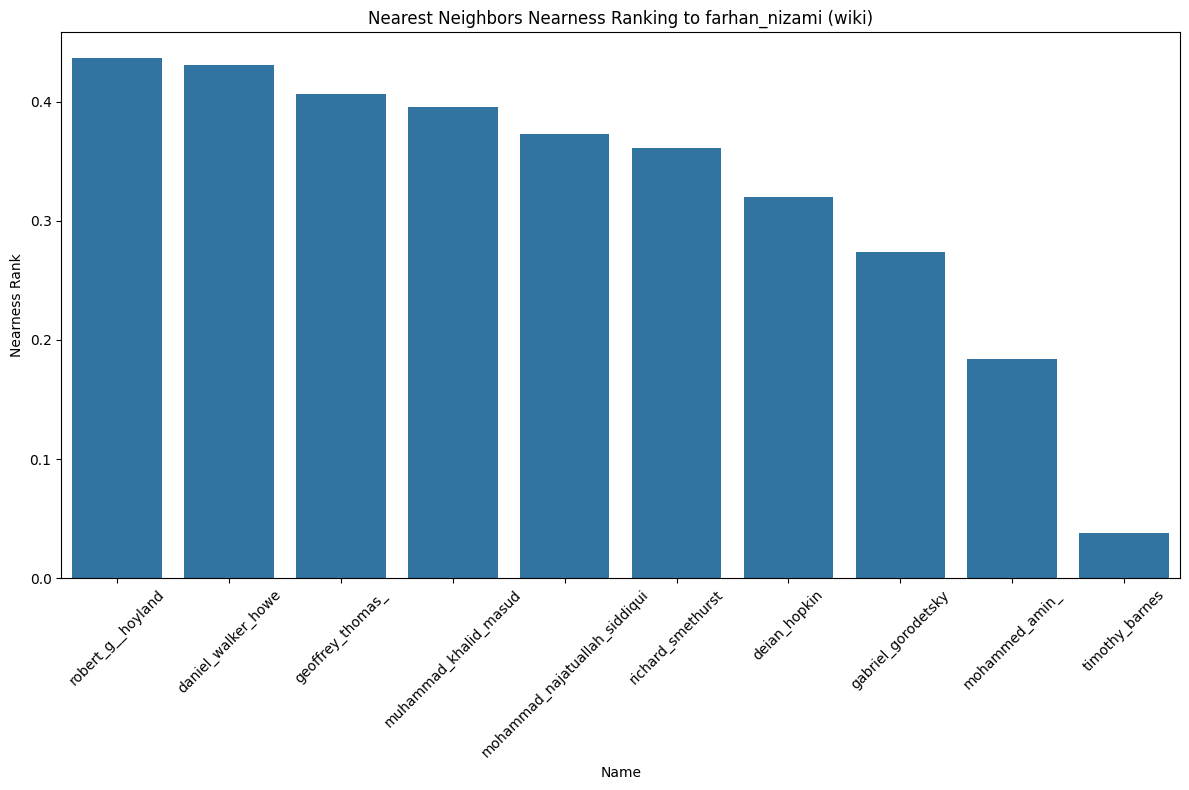

In [194]:
# plot nearest neighbors
plt.figure(figsize=(12, 8))
sns.barplot(x='name', y='nearness_rank_wiki', data=neighbors_df1)
plt.xlabel('Name')
plt.ylabel('Nearness Rank')
plt.title(f'Nearest Neighbors Nearness Ranking to {target_name} (wiki)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## P1 BoW: Nearness Ranking

In [195]:
# add column dfpedia_text and nearness_rank_dfpedia to neighbors_df
neighbors_df['dfpedia_text'] = "tbd"
neighbors_df

,wiki_text,name,nearness_rank_wiki,dfpedia_text
10,Farhan Nizami CBE is a historian of South Asia...,farhan_nizami,1.000000,tbd
3,"Robert G. Hoyland (born 1966) is a historian, ...",robert_g__hoyland,0.436550,tbd
2,"Daniel Walker Howe (born January 10, 1937) is ...",daniel_walker_howe,0.430928,tbd
0,Geoffrey Price Thomas FLSW (born 3 July 1941) ...,geoffrey_thomas_,0.406894,tbd
9,Muhammad Khalid Masud (born 15 April 1939) is ...,muhammad_khalid_masud,0.395748,tbd
6,Mohammad Nejatullah Siddiqi (1931 – November 2...,mohammad_najatuallah_siddiqui,0.372647,tbd
8,Richard Good Smethurst (born 17 January 1941) ...,richard_smethurst,0.361582,tbd
5,Sir Deian Rhys Hopkin (born 1 March 1944) is a...,deian_hopkin,0.319786,tbd
4,Gabriel Gorodetsky (Hebrew: גבריאל גורודצקי; b...,gabriel_gorodetsky,0.274109,tbd
7,Mohammed Amin is a British Pakistani business...,mohammed_amin_,0.184090,tbd


In [196]:
# add dfpedia text from names_df to neighbors_df
for index, row in neighbors_df.iterrows():
  neighbors_df.loc[index, 'dfpedia_text'] = names_df1[names_df1['name'] == row['name']]['text'].values[0]

# order by index
neighbors_df.sort_index(inplace=True)

neighbors_df

,wiki_text,name,nearness_rank_wiki,dfpedia_text
0,Geoffrey Price Thomas FLSW (born 3 July 1941) ...,geoffrey_thomas_,0.406894,geoffrey price thomas born 3 july 1941 was pre...
1,Timothy or Tim Barnes may refer to: Timothy B...,timothy_barnes,0.038119,timothy david barnes born 1942 is a british cl...
2,"Daniel Walker Howe (born January 10, 1937) is ...",daniel_walker_howe,0.430928,daniel walker howe born january 10 1937 is an ...
3,"Robert G. Hoyland (born 1966) is a historian, ...",robert_g__hoyland,0.436550,robert g hoyland is a scholar and historian sp...
4,Gabriel Gorodetsky (Hebrew: גבריאל גורודצקי; b...,gabriel_gorodetsky,0.274109,gabriel gorodetsky born 13 may 1945 is a quond...
5,Sir Deian Rhys Hopkin (born 1 March 1944) is a...,deian_hopkin,0.319786,sir deian rhys hopkin born 1 march 1944 is pre...
6,Mohammad Nejatullah Siddiqi (1931 – November 2...,mohammad_najatuallah_siddiqui,0.372647,mohammad nejatullah siddiqi urdu is an indian ...
7,Mohammed Amin is a British Pakistani business...,mohammed_amin_,0.184090,mohammed amin is a british muslim who is vice ...
8,Richard Good Smethurst (born 17 January 1941) ...,richard_smethurst,0.361582,richard good smethurst born 17 january 1941 wa...
9,Muhammad Khalid Masud (born 15 April 1939) is ...,muhammad_khalid_masud,0.395748,muhammad khalid masud born april 15 1939 is th...


In [197]:
# vectorize using Bag of Words
bow_matrix_dfpedia = vectorizer.fit_transform(neighbors_df['dfpedia_text'].astype(str).tolist())

# find cosine similarity between entries
target_row_dfpedia = neighbors_df[neighbors_df['name'] == target_name]
target_index_dfpedia = target_row_dfpedia.index[0]
cos_similarities_dfpedia = cosine_similarity(bow_matrix_dfpedia[target_index_dfpedia], bow_matrix_dfpedia).flatten()

# add nearness ranking to df and order by nearness
neighbors_df['nearness_rank_dfpedia'] = cos_similarities_dfpedia
neighbors_df.sort_values(by='nearness_rank_dfpedia', ascending=False, inplace=True,)

neighbors_df

,wiki_text,name,nearness_rank_wiki,dfpedia_text,nearness_rank_dfpedia
10,Farhan Nizami CBE is a historian of South Asia...,farhan_nizami,1.000000,farhan nizami cbe is the prince of wales fello...,1.000000
0,Geoffrey Price Thomas FLSW (born 3 July 1941) ...,geoffrey_thomas_,0.406894,geoffrey price thomas born 3 july 1941 was pre...,0.455967
1,Timothy or Tim Barnes may refer to: Timothy B...,timothy_barnes,0.038119,timothy david barnes born 1942 is a british cl...,0.407263
2,"Daniel Walker Howe (born January 10, 1937) is ...",daniel_walker_howe,0.430928,daniel walker howe born january 10 1937 is an ...,0.404844
3,"Robert G. Hoyland (born 1966) is a historian, ...",robert_g__hoyland,0.436550,robert g hoyland is a scholar and historian sp...,0.395369
4,Gabriel Gorodetsky (Hebrew: גבריאל גורודצקי; b...,gabriel_gorodetsky,0.274109,gabriel gorodetsky born 13 may 1945 is a quond...,0.392361
5,Sir Deian Rhys Hopkin (born 1 March 1944) is a...,deian_hopkin,0.319786,sir deian rhys hopkin born 1 march 1944 is pre...,0.388231
6,Mohammad Nejatullah Siddiqi (1931 – November 2...,mohammad_najatuallah_siddiqui,0.372647,mohammad nejatullah siddiqi urdu is an indian ...,0.382677
7,Mohammed Amin is a British Pakistani business...,mohammed_amin_,0.184090,mohammed amin is a british muslim who is vice ...,0.377319
8,Richard Good Smethurst (born 17 January 1941) ...,richard_smethurst,0.361582,richard good smethurst born 17 january 1941 wa...,0.374726


In [206]:
# make a copy
neighbors_df2 = neighbors_df.copy()

In [207]:
# reset index and drop target name
neighbors_df2.reset_index(drop=True, inplace=True)
neighbors_df2.drop(neighbors_df2[neighbors_df2['name'] == target_name].index, inplace=True)

neighbors_df2

,wiki_text,name,nearness_rank_wiki,dfpedia_text,nearness_rank_dfpedia
1,Geoffrey Price Thomas FLSW (born 3 July 1941) ...,geoffrey_thomas_,0.406894,geoffrey price thomas born 3 july 1941 was pre...,0.455967
2,Timothy or Tim Barnes may refer to: Timothy B...,timothy_barnes,0.038119,timothy david barnes born 1942 is a british cl...,0.407263
3,"Daniel Walker Howe (born January 10, 1937) is ...",daniel_walker_howe,0.430928,daniel walker howe born january 10 1937 is an ...,0.404844
4,"Robert G. Hoyland (born 1966) is a historian, ...",robert_g__hoyland,0.436550,robert g hoyland is a scholar and historian sp...,0.395369
5,Gabriel Gorodetsky (Hebrew: גבריאל גורודצקי; b...,gabriel_gorodetsky,0.274109,gabriel gorodetsky born 13 may 1945 is a quond...,0.392361
6,Sir Deian Rhys Hopkin (born 1 March 1944) is a...,deian_hopkin,0.319786,sir deian rhys hopkin born 1 march 1944 is pre...,0.388231
7,Mohammad Nejatullah Siddiqi (1931 – November 2...,mohammad_najatuallah_siddiqui,0.372647,mohammad nejatullah siddiqi urdu is an indian ...,0.382677
8,Mohammed Amin is a British Pakistani business...,mohammed_amin_,0.184090,mohammed amin is a british muslim who is vice ...,0.377319
9,Richard Good Smethurst (born 17 January 1941) ...,richard_smethurst,0.361582,richard good smethurst born 17 january 1941 wa...,0.374726
10,Muhammad Khalid Masud (born 15 April 1939) is ...,muhammad_khalid_masud,0.395748,muhammad khalid masud born april 15 1939 is th...,0.373012


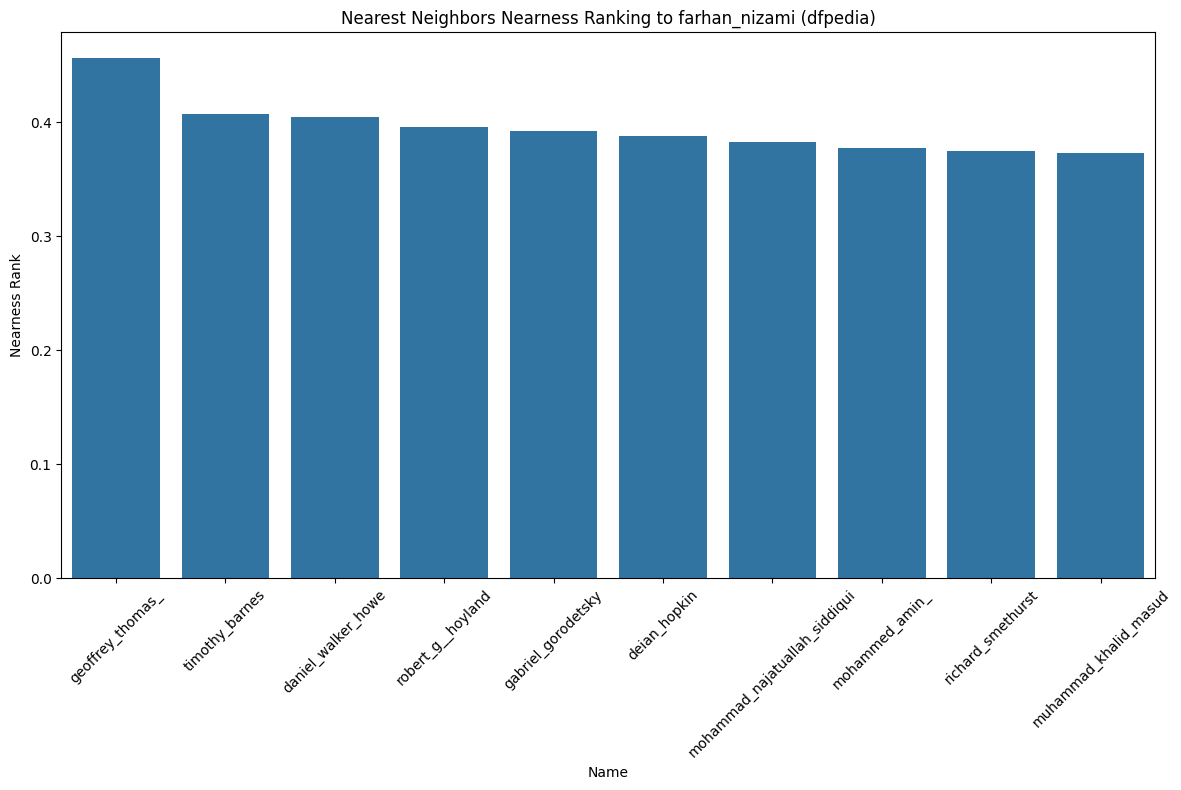

In [210]:
# plot nearness neighbors from dfpedia
plt.figure(figsize=(12, 8))
sns.barplot(x='name', y='nearness_rank_dfpedia', data=neighbors_df2)
plt.xlabel('Name')
plt.ylabel('Nearness Rank')
plt.title(f'Nearest Neighbors Nearness Ranking to {target_name} (dfpedia)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Part 3)


##Interactive Cell

Make an interactive notebook where a user can choose or enter a name and the notebook displays the 10 closest individuals.

In addition to presenting the project slides, at the end of the presentation each student will demonstrate their code using a famous person suggested by the other students that exists in the DBpedia set.


Make a drop down text box where you can select or type in a name from names_df and find the 10 closest neighbors

In [268]:
# make list of names from names_df
names_df.sort_values(by='name', inplace=True)
for index, row in names_df.head(30).iterrows():
  if '%' in row['name']:
    encoded_name = row['name']
    decoded_name = urllib.parse.unquote(encoded_name)
    names_df.loc[index, 'name'] = decoded_name
  else:
    pass

names_list = names_df['name'].tolist()
names_list

# make dropdown list
dropdown = widgets.Combobox(
    placeholder = 'type here',
    options = names_list,
    description='Select a name:',
    ensure_option=True,
    disabled=False
)

# display the dropdown
display(dropdown)

# bank the selection
def on_select(change):
  global selection
  print(f"You selected: {change.new}")
  selection = change.new

dropdown.observe(on_select, names='value')

# find corresponding name in names_df1
selection_name = names_df1[names_df['name'] == selection]['name'].values[0]

# target row
selection_row = names_df1[names_df1['name'] == selection_name]

# vectorize using Bag of Words
bow_matrix = vectorizer.fit_transform(all_text)

# find cosine similarity between entries
target_index = selection_row.index[0]
selection_cos_similarities = cosine_similarity(bow_matrix[target_index], bow_matrix).flatten()

# get top 10 similar people (excluding self)
selection_similar_indices = selection_cos_similarities.argsort()[-11:-1][::-1]
selection_similar_people = names_df1.iloc[selection_similar_indices][['name', 'text']]

# return similar people
print(f"\nTop 10 people similar to '{selection_name}':")
for i, row in selection_similar_people.iterrows():
    print(f"- {row['name']}")

# sentiment analysis of target person's overview
selection_overview = selection_row['text'].values[0]
selection_sentiment = TextBlob(selection_overview).sentiment
print(f"\nSentiment of {selection_name}'s overview:")
print(f"Polarity: {selection_sentiment.polarity:.2f}, Subjectivity: {selection_sentiment.subjectivity:.2f}")

Combobox(value='', description='Select a name:', ensure_option=True, options=(' Renate Lorenz', "'Ilima Lei To…

<ipython-input-268-bbdd6e4ca9b3>:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  selection_name = names_df1[names_df['name'] == selection]['name'].values[0]



Top 10 people similar to 'relton_roberts':
- digby_morrell
- karl_norman
- richard_ambrose
- nick_salter
- andrew_mckay
- lindsay_smith_
- jarrod_silvester
- sean_okeeffe
- scott_mcmahon
- clayton_collard

Sentiment of relton_roberts's overview:
Polarity: -0.04, Subjectivity: 0.30
You selected: Relton Roberts
